In [6]:
### Imports
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\Unmasking power\\UP codebase')
from itertools import product
from statsmodels.stats.proportion import proportion_confint
import src.folders as folders
import src.power as power
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.rcParams.update({'font.family': 'arial'})
title_fontdict = {'fontsize': 16, 'fontweight': 'bold'}
axislabel_fontdict = {'fontsize': 14, 'fontweight': 'bold'}
ticklabel_fontsize = 12

dir_out=os.path.join(folders.exports, 'Prob CGR in CI')
def save_fig(fig, fname, dir_out=dir_out):
    for fileformat in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(dir_out, f'{fname}.{fileformat}'),
            bbox_inches='tight',
            format=fileformat,
            dpi=300,)

In [7]:
### Generate mock data
n_trials = 600
sample = 500
samples = [int(sample) for sample in np.arange(10, sample+10, 10)] 
sim_cgrs = [round(cgr,2) for cgr in np.arange(0.55, 0.91, 0.01)]

df_patientsData=[]
for sim_cgr in sim_cgrs:
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'{str(sim_cgr)}', 
            n_trials = n_trials, 
            sample = sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': sim_cgr},
                    'T': {'cgr': sim_cgr},},}]))       
df_patientsData = pd.concat(df_patientsData, ignore_index=True)

### Calculate CIs
df_CIs = power.FreqStats.get_df_cgrCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples,) 
df_CIs = power.FreqStats.add_sigdiff(df_CIs)
df_CIs.head(3)

### Bookkeeping
df_patientsData = df_patientsData.rename(columns={'scenario': 'sim_cgr'})
df_CIs = df_CIs.rename(columns={'scenario': 'sim_cgr'})
df_CIs.head(3)

,sim_cgr,trial,sample,cgr,cgr_ciL,cgr_ciH,cgr_moe,cgr_sigdiff
0,0.55,0,10,0.600,0.262,0.878,0.308,False
1,0.55,0,20,0.500,0.272,0.728,0.228,False
2,0.55,0,30,0.567,0.374,0.745,0.186,False


In [8]:
### Calculate avg across trials for each CGR and sample size
# Loop based calculation
sim_cgrs = df_CIs['sim_cgr'].unique()
samples = df_CIs['sample'].unique()

rows=[]
for sim_cgr, sample in product(sim_cgrs, samples):
    
    df_tmp = df_CIs.loc[
            (df_CIs['sim_cgr']==sim_cgr) & 
            (df_CIs['sample']==sample)]
    
    if df_tmp.shape[0]!=n_trials:
        print(f'Not enough trials for sim_cgr={sim_cgr}, sample={sample}')
        continue

    row = {}
    row['sim_cgr'] = sim_cgr
    row['sample'] = sample
    row['ratio_sigdiff'] = df_tmp['cgr_sigdiff'].mean()
    rows.append(row)
df_CIs_avg = pd.DataFrame(rows)

### Quicker with groupby - checked, results are NOT same
# df_CIs_avg = df_CIs.groupby(['sample', 'sim_cgr']).agg(ratio_sigdiff=('cgr_sigdiff', 'mean')).reset_index()
# df_CIs_avg.to_csv('tmp2.csv', index=False)
df_CIs_avg.to_csv('tmp.csv', index=False)
df_CIs_avg.head(3)

,sim_cgr,sample,ratio_sigdiff
0,0.55,10,0.030
1,0.55,20,0.065
2,0.55,30,0.070


In [9]:
### Find sample size of p(unmask)=thr as function of CGR
assert df_CIs_avg.columns.get_loc('ratio_sigdiff')==2
thr=0.8
sim_cgrs = df_CIs_avg['sim_cgr'].unique()
samples = df_CIs_avg['sample'].unique()

rows=[]
for sim_cgr in sim_cgrs:
    min_sample = None
    for sample in samples:
        
        df_tmp = df_CIs_avg.loc[
                (df_CIs_avg['sim_cgr']==sim_cgr) & 
                (df_CIs_avg['sample']==sample)]

        assert len(df_tmp)==1
        ratio_sigdiff = df_tmp.iloc[0, 2]

        if (ratio_sigdiff>=thr) and ((min_sample is None) or (sample<min_sample)):
            min_sample = sample

    row={}
    row['sim_cgr'] = sim_cgr
    row['sample'] = min_sample
    rows.append(row)

df_const_p_unmask = pd.DataFrame(rows)
# df_const_p_unmask.to_csv('tmp2.csv', index=False)

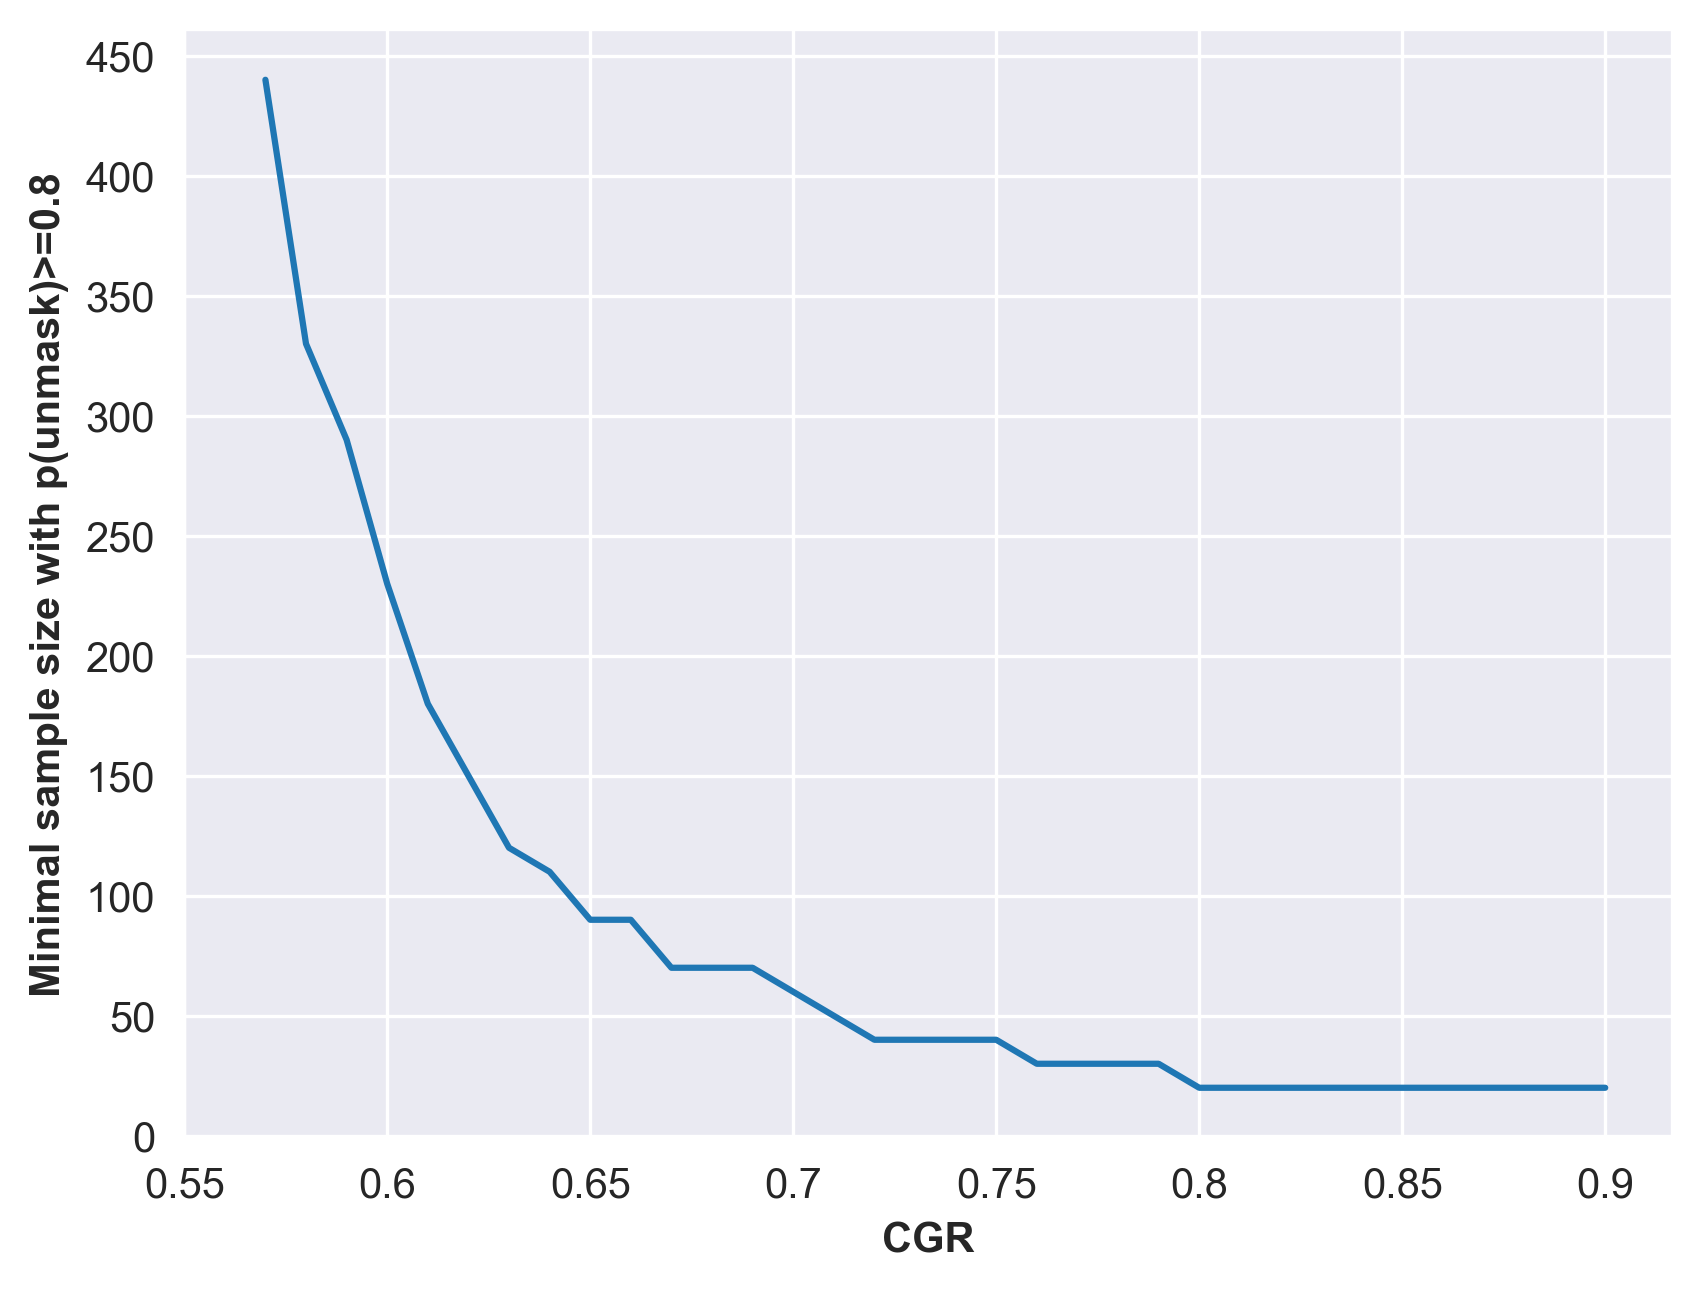

In [16]:
### Unmasking power plot (CGR)
fig, ax = plt.subplots()
sns.lineplot(
    data = df_const_p_unmask,
    x = 'sim_cgr', 
    y = 'sample',)

#plt.title('CGR vs. minimal sample size with p(unmask)=0.8', fontweight='bold', fontsize=16)
ax.set_xlabel('CGR', fontweight='bold')
ax.set_ylabel('Minimal sample size with p(unmask)>=0.8', fontweight='bold')
ax.set_xticks(['0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9',])
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])

save_fig(fig, 'cgr_vs_sample_p_unmask08')
plt.show()